
<div style="background: linear-gradient(135deg, #fbeee0 0%, #f6d1c1 100%); padding: 1.5rem; border-radius: 20px; text-align: center; color: #6e4c1e; font-family: 'Playfair Display', cursive; box-shadow: 0 8px 24px rgba(0,0,0,0.2); max-width: 900px; margin: auto;">
  <h1 style="margin: 0; font-size: 2.5rem; color: #d98880; text-shadow: 1px 1px 2px rgba(0,0,0,0.2);">
     Face Aging with Conditional GAN 
  </h1>
  <p style="margin: .5rem 0 1rem; text-align: center; font-size: 1.1rem;">Exploring Beauty Through the Lens of Time</p>
  <img src="https://scaleway.com/cdn-cgi/image/width=1200/https://www-uploads.scaleway.com/giphy_dont_worry_this_nightmare_does_not_exist_either_fb6b3fb513.gif"
       alt="GAN demo"
       style="width: 30%; border-radius: 16px; box-shadow: 0 4px 16px rgba(0,0,0,0.15); display: block; margin: auto;" />
</div>

<div style="background: #fff9f5; padding: 1.5rem; border-radius: 20px; color: #5e4b3c; font-family: 'Lora', serif; max-width: 800px; margin: 2rem auto; box-shadow: 0 4px 16px rgba(0,0,0,0.1);">
  <p style="font-size: 1.1rem; margin-bottom: 1rem;">
    This gentle notebook walks through a little journey with a <strong style="color: #cb4335;">Conditional GAN</strong> trained on the <strong style="color: #cb4335;">Wiki-Crop</strong> dataset — all to bring faces to life as they gracefully age.
  </p>
  <p style="font-size: 1.1rem; margin-bottom: 1.5rem;">
    You'll see how machine learning can imagine age with elegance — from youth to maturity, and everything in between .
  </p>
  <ul style="list-style: none; padding: 0;">
    <li style="background: #f9e0d9; padding: .8rem 1.2rem; border-radius: 10px; margin-bottom: .8rem;">
      <strong>📸 Dataset:</strong> Lovely, annotated portraits from the <code style="background: rgba(255,255,255,.3); padding: .2rem .4rem; border-radius: 4px;">wiki_crop</code> collection.
    </li>
    <li style="background: #f9e0d9; padding: .8rem 1.2rem; border-radius: 10px; margin-bottom: .8rem;">
      <strong>✨ Preprocessing:</strong> We gently cleaned, grouped, and prepped each image by age .
    </li>
    <li style="background: #f9e0d9; padding: .8rem 1.2rem; border-radius: 10px; margin-bottom: .8rem;">
      <strong>🎨 Model:</strong> A deep, thoughtful Generator & Discriminator — both conditioned on the age vibes 💡.
    </li>
    <li style="background: #f9e0d9; padding: .8rem 1.2rem; border-radius: 10px; margin-bottom: .8rem;">
      <strong>📚 Training:</strong> Watched the model bloom over epochs — output grids & sweet loss curves included.
    </li>
    <li style="background: #f9e0d9; padding: .8rem 1.2rem; border-radius: 10px; margin-bottom: .8rem;">
      <strong>🔍 Evaluation:</strong> Side-by-side glimpses across age bands — teen to wise grandma 🧓.
    </li>
  </ul>
  <p style="text-align: center; margin-top: 2rem;">
    <a href="#Generator samples from training" style="display: inline-block; padding: .7rem 1.4rem; background: #f5b7b1; color: #fff; border-radius: 12px; text-decoration: none; font-weight: bold; box-shadow: 0 4px 8px rgba(0,0,0,0.1); transition: background .3s;">
      See the Magic Happen →
    </a>
  </p>
</div>

<hr style="border: none; height: 3px; background: linear-gradient(90deg, #f5b7b1, #fadbd8); margin: 3rem auto; width: 60%;" />


# Downloading the dataset

In [1]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
!tar -xf wiki_crop.tar

--2025-05-27 08:41:59--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  28.4MB/s    in 29s     

2025-05-27 08:42:28 (26.8 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



In [2]:
import math
import os
import time
from datetime import datetime
from pathlib import Path
from glob import glob

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Prepare Data

In [3]:
def calc_age(taken, dob):
    '''
    Calculate age
    '''
    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [4]:
def load_data(dataset='wiki', data_dir='./wiki_crop'):
    '''
    Load meta data and calculate age
    
    '''
    # meta data
    meta_path = Path(data_dir) / f'{dataset}.mat'
    meta = loadmat(meta_path)
    meta_data = meta[dataset][0, 0]

   
    full_path = meta_data['full_path'][0]
    full_path = [y for x in full_path for y in x]

  
    dob = meta_data['dob'][0]

    photo_taken = meta_data['photo_taken'][0]

    # Calculate age
    age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]
    
    # Clean mapping with age > 0
    clean_mapping = {pth:age for (pth, age) in zip(full_path, age) if age > 0}
    
    full_path = list(clean_mapping.keys())
    age = list(clean_mapping.values())

    return full_path, age

In [5]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1.'''
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [6]:
# helper one-hot function
bins = [18, 29, 39, 49, 59]
def one_hot(x, bins):
    '''
    Convert tensor x to one-hot tensor
    
    '''
    x = x.numpy()
    idxs = np.digitize(x, bins, right=True)
    idxs = idxs.reshape(-1,1)
    z = torch.zeros(len(x), len(bins)+1).scatter_(1, torch.tensor(idxs), 1)
    return z

# Data Loader

In [7]:
class ImageAgeDataset(Dataset):
    '''Image and corresponding age Dataset'''
    def __init__(self, dataset, data_dir, transform=None):
        self.data_dir = data_dir
        self.full_path, self.age = load_data(dataset, data_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.age)
    
    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.data_dir, self.full_path[idx]))
        age = self.age[idx]
        sample = {'image': image, 'age': age}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [8]:
class Resize(object):
    '''Resize the input PIL Image to the given size.'''
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.Resize(self.output_size)(image)
        return {'image': image, 'age': age}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.ToTensor()(image)
        # expand dept from 1 to 3 channels for gray images
        if image.size()[0] == 1:
            image = image.expand(3,-1,-1)
        return {'image': image, 'age': age}

In [9]:
dataset='wiki'
data_dir='./wiki_crop'
bins = [18, 29, 39, 49, 59]
img_size = 64
batch_size = 128
#num_workers = 0

tfms = transforms.Compose([Resize((img_size, img_size)),
                           ToTensor()])

train_dataset = ImageAgeDataset(dataset, data_dir, transform=tfms)

# build DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

In [10]:
next(iter(train_loader))

{'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.3137, 0.2941, 0.3373],
           [1.0000, 1.0000, 1.0000,  ..., 0.3137, 0.3020, 0.3412],
           [1.0000, 1.0000, 1.0000,  ..., 0.3137, 0.3020, 0.3451],
           ...,
           [0.0902, 0.0784, 0.0941,  ..., 0.1176, 0.0353, 0.0235],
           [0.1098, 0.0863, 0.0902,  ..., 0.0902, 0.0157, 0.0353],
           [0.1216, 0.0941, 0.0824,  ..., 0.0745, 0.0235, 0.0627]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 0.3373, 0.3059, 0.3490],
           [1.0000, 1.0000, 1.0000,  ..., 0.3412, 0.3137, 0.3529],
           [1.0000, 1.0000, 1.0000,  ..., 0.3373, 0.3137, 0.3569],
           ...,
           [0.2431, 0.2353, 0.2588,  ..., 0.3255, 0.2745, 0.2627],
           [0.2510, 0.2314, 0.2392,  ..., 0.3098, 0.2627, 0.2745],
           [0.2667, 0.2431, 0.2431,  ..., 0.2941, 0.2627, 0.2941]],
 
          [[1.0000, 1.0000, 1.0000,  ..., 0.3686, 0.3412, 0.3843],
           [1.0000, 1.0000, 1.0000,  ..., 0.3725, 0.3490, 0.3882],
           [1.0

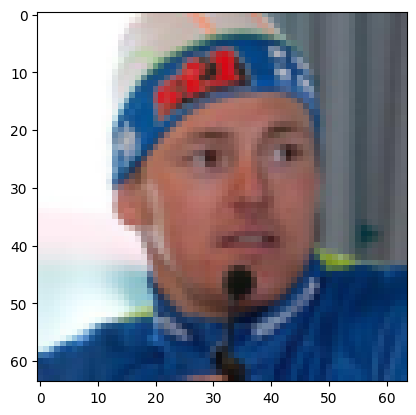

In [11]:
plt.imshow(train_dataset[0]['image'].numpy().transpose(1,2,0))

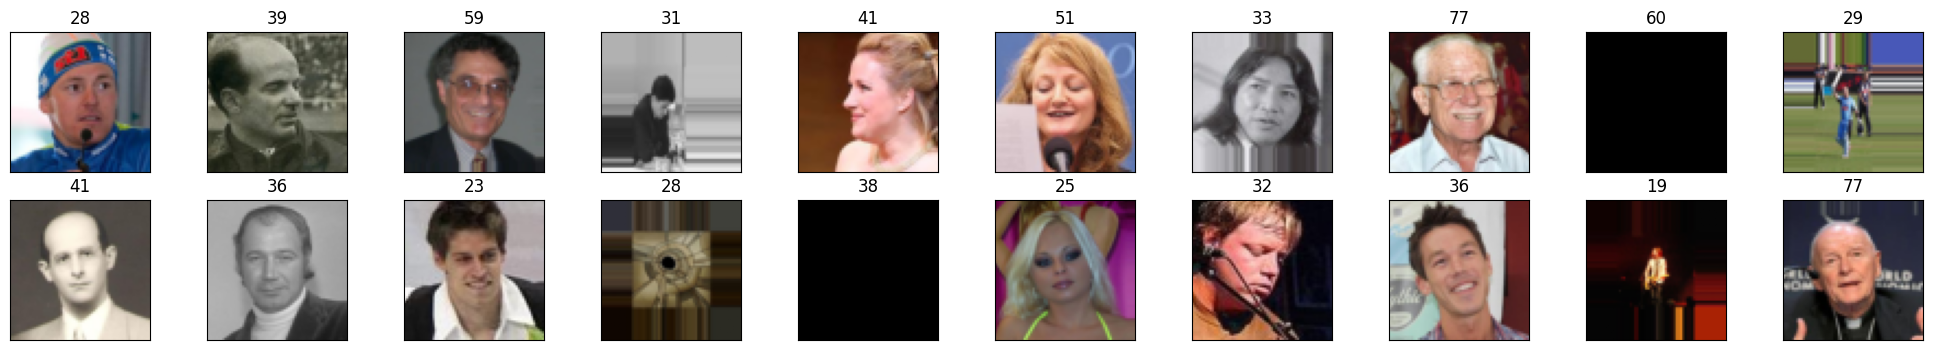

In [12]:
# obtain one batch of training images
dataiter = iter(train_loader)
data = next(dataiter)
images, labels = data['image'], data['age']


fig = plt.figure(figsize=(25, 4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(str(labels[idx].item()))


# Define Models

## Discriminator

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
# Helpers
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if batch_norm:
        bn = nn.BatchNorm2d(out_channels)
        layers.append(bn)
        
    return nn.Sequential(*layers)

In [15]:
class Discriminator(nn.Module):
    
    def __init__(self, y_size, conv_dim=64):
        '''
        Initialize the Discriminator Module
        
        '''
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.y_size = y_size
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim+y_size, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.conv5 = conv(conv_dim*8, 1, 4, 1, 0, batch_norm=False)
            
    def forward(self, x, y):
        '''
        Forward propagation of the neural network
    
        '''
        x = F.relu(self.conv1(x))
        y = y.view(-1,y.size()[-1],1,1)
        y = y.expand(-1,-1,x.size()[-2], x.size()[-1])
        x = torch.cat([x, y], 1)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        
        return x

## Generator

In [16]:
# Helpers
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    
    layers = []
    t_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(t_conv)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [17]:
class Generator(nn.Module):
    
    def __init__(self, z_size, y_size, conv_dim=64):
        '''
        Initialize the Generator Module

        '''
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # self.fc = nn.Linear(z_size+y_size, conv_dim*8*4*4)
        self.t_conv1 = deconv(z_size+y_size, conv_dim*8, 4, 1, 0)
        self.t_conv2 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv3 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv4 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv5 = deconv(conv_dim, 3, 4, batch_norm=False)
        
    def forward(self, z, y):
        '''
        Forward propagation of the neural network
 
        '''
        x = torch.cat([z, y], dim=1)
        x = x.view(-1, x.size()[-1], 1, 1)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = self.t_conv5(x)
        x = torch.tanh(x)
        
        return x

## Build complete network

In [18]:
# define hyperparams
conv_dim = 64
z_size = 100
y_size = 6 # no. of age classes


D = Discriminator(y_size, conv_dim)
G = Generator(z_size, y_size, conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(70, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Generator(
  (t_conv1): Sequential(
    (0): ConvTranspose2d(106, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05,

## Discriminator and Generator Losses

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [20]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
        
    labels = labels.to(device)
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [21]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training

In [22]:
def checkpoint(G, D, epoch, model, root_dir):
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    G_path = os.path.join(target_dir, f'G_{epoch}.pkl')
    D_path = os.path.join(target_dir, f'D_{epoch}.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def oh_to_class(fixed_y):
    age_map = {0:'0-18',1:'19-29',2:'30-39',3:'40-49',4:'50-59',5:'60+'}
    if torch.cuda.is_available():
        fixed_y = fixed_y.cpu()
    fixed_y_idxs = fixed_y.numpy().nonzero()[1]
    fixed_y_ages = [age_map[idx] for idx in fixed_y_idxs]
    
    return fixed_y_ages

def save_samples_ages(samples, fixed_y, model, root_dir):
    fixed_y_ages = oh_to_class(fixed_y)
    samples_ages = {'samples': samples, 'ages': fixed_y_ages}
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    with open(f'{target_dir}/train_samples_ages.pkl', 'wb') as f:
        pkl.dump(samples_ages, f)

In [23]:
%%time

root_dir = '/content/Age-cGAN'
model = 'GAN_1'
os.makedirs(root_dir, exist_ok=True)

G.to(device)
D.to(device)

import pickle as pkl

# training hyperparams
num_epochs = 50

samples = []
losses = []

print_every = 300


sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_y = np.random.randint(len(bins), size=sample_size)
fixed_y = fixed_y.reshape(-1,1)
fixed_y = torch.zeros(sample_size, len(bins)+1).scatter_(1, torch.tensor(fixed_y), 1)

# train the network
for epoch in range(num_epochs):
    
    for batch_i, batch in enumerate(train_loader):
                
        batch_size = batch['image'].size(0)
        real_images = scale(batch['image'])
        ages = one_hot(batch['age'], bins)
        d_optimizer.zero_grad()
        real_images = real_images.to(device)
        ages = ages.to(device)       
        D_real = D(real_images, ages)
        d_real_loss = real_loss(D_real)
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z, ages)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images, ages)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        

        g_optimizer.zero_grad()
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z, ages)
        D_fake = D(fake_images, ages)
        g_loss = real_loss(D_fake) 
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            losses.append((d_loss.item(), g_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))


    G.eval() # for generating samples
    fixed_z = fixed_z.to(device)
    fixed_y = fixed_y.to(device)
    samples_z = G(fixed_z, fixed_y)
    samples.append(samples_z)
    G.train() # back to training mode
    
    # Save checkpoint
    checkpoint(G, D, epoch, model, root_dir)

# Save training generator samples
save_samples_ages(samples, fixed_y, model, root_dir)


Epoch [    1/   50] | d_loss: 1.4701 | g_loss: 1.8935
Epoch [    1/   50] | d_loss: 0.6670 | g_loss: 2.5011
Epoch [    2/   50] | d_loss: 0.5701 | g_loss: 3.0535
Epoch [    2/   50] | d_loss: 0.5131 | g_loss: 2.4878
Epoch [    3/   50] | d_loss: 0.9319 | g_loss: 4.3324
Epoch [    3/   50] | d_loss: 0.4313 | g_loss: 2.0804
Epoch [    4/   50] | d_loss: 0.5371 | g_loss: 2.8957
Epoch [    4/   50] | d_loss: 0.3613 | g_loss: 3.6558
Epoch [    5/   50] | d_loss: 0.4222 | g_loss: 2.2873
Epoch [    5/   50] | d_loss: 0.2355 | g_loss: 3.6143
Epoch [    6/   50] | d_loss: 0.3921 | g_loss: 2.8268
Epoch [    6/   50] | d_loss: 0.2200 | g_loss: 4.1027
Epoch [    7/   50] | d_loss: 0.9192 | g_loss: 4.3924
Epoch [    7/   50] | d_loss: 0.2106 | g_loss: 3.2866
Epoch [    8/   50] | d_loss: 1.0609 | g_loss: 6.1509
Epoch [    8/   50] | d_loss: 0.2368 | g_loss: 3.7350
Epoch [    9/   50] | d_loss: 0.1771 | g_loss: 1.9216
Epoch [    9/   50] | d_loss: 0.0847 | g_loss: 3.7444
Epoch [   10/   50] | d_loss

## Training loss

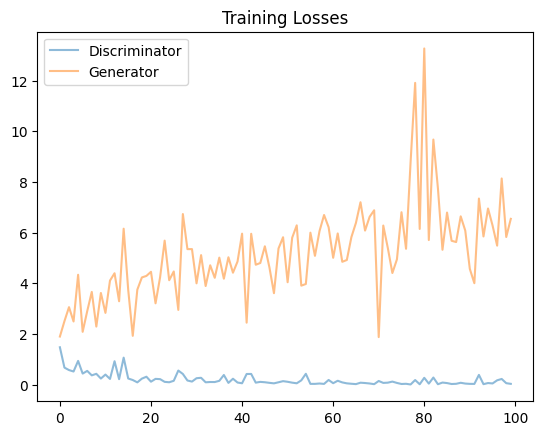

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [25]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples, ages):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img, age in zip(axes.flatten(), samples[epoch], ages):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(age)
        im = ax.imshow(img.reshape((64,64,3)))

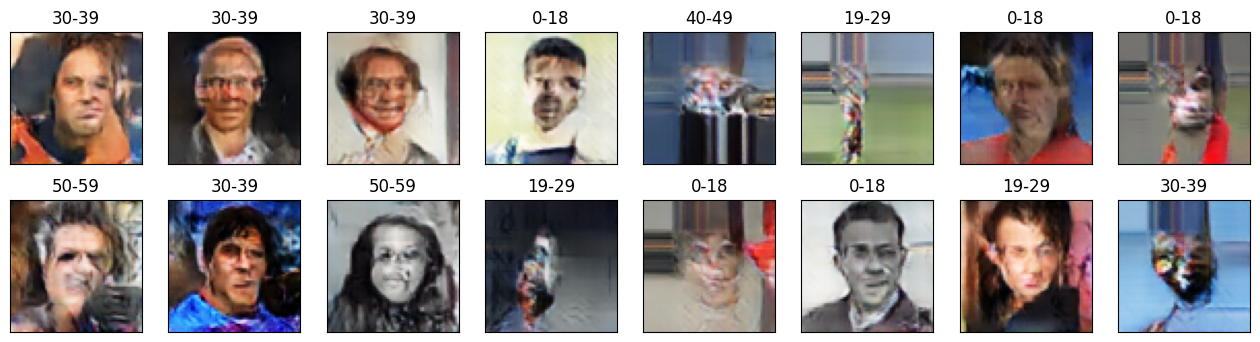

In [26]:
fixed_y_ages = oh_to_class(fixed_y)
_ = view_samples(-1, samples, fixed_y_ages)

In [27]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.1 MB/s eta 0:00:00


## User Interface

In [28]:
import gradio as gr
import torch
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt


G.eval()

def generate_old_face(age_group):
   
    z = np.random.uniform(-1, 1, size=(1, z_size)).astype(np.float32)
    z = torch.from_numpy(z).to(device)

    
    age_index = bins.index(age_group)
    y = torch.zeros(1, len(bins)+1).to(device)
    y[0][age_index] = 1

    
    with torch.no_grad():
        generated_img = G(z, y).cpu()

   
    img_grid = vutils.make_grid(generated_img, normalize=True)
    img_np = img_grid.permute(1, 2, 0).numpy()

    
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("aged_output.png")
    plt.close()

    return "aged_output.png"


age_labels = [f"{b}+" for b in bins]

# Gradio app
iface = gr.Interface(
    fn=generate_old_face,
    inputs=[
        gr.Dropdown(age_labels, label="Select Age Group to Generate")
    ],
    outputs=gr.Image(type="filepath", label="Aged Face"),
    title="Age Progression with Age-cGAN",
    description="Select an age group and see how your face might look!"
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://aed861e5ceca94e123.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
